In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import src.utils as utils
from src.model import Nonneg_dagma

from colide.model import colide_ev
from colide.utils import count_accuracy 

SEED = 10
N_CPUS = os.cpu_count() // 2
np.random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Experiment function
def run_samples_exp(g, data_p, N_samples, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = [np.zeros((len(N_samples), len(exps)))  for _ in range(8)]
    for i, n_samples in enumerate(N_samples):
        print(f'Graph: {g+1}, samples: {n_samples}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_samples'] = n_samples
        W_true, _, X = utils.simulate_sem(**data_p_aux)
        X_norm = X/np.linalg.norm(X, axis=1, keepdims=True)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_norm if 'norm_x' in exp.keys() and exp['norm_x'] else X

            arg_aux = exp['args'].copy()
            if exp['args']['lamb'] == 'adaptive':
                arg_aux['lamb'] = np.sqrt(np.log(data_p['n_nodes'])/n_samples)*2e-2

            model = exp['model']()
            t_init = perf_counter()
            model.fit(X_aux, **arg_aux)
            t_end = perf_counter()

            W_est_bin = utils.to_bin(model.W_est, thr)
            
            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, model.W_est, norm_W_true)
            acyc[i,j] = model.dagness(model.W_est) if hasattr(model, 'dagness') else 1
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb:
                print(f'\t\t-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count


def plot_data(axes, data, exps, x_vals, xlabel, ylabel, skip_idx=[], agg='mean'):
    if agg == 'median':
        agg_data = np.median(data, axis=0)
    else:
        agg_data = np.mean(data, axis=0)

    for i, exp in enumerate(exps):
        if i in skip_idx:
            continue
        axes.semilogx(x_vals, agg_data[:,i], exp['fmt'], label=exp['leg'])
    
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.grid(True)
    axes.legend()

def plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, x_vals, exps, 
                     agg='mean', skip_idx=[]):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    plot_data(axes[0], shd, exps, x_vals, 'Number of samples', 'SDH', agg=agg)
    plot_data(axes[1], tpr, exps, x_vals, 'Number of samples', 'TPR', agg=agg)
    plot_data(axes[2], fdr, exps, x_vals, 'Number of samples', 'FDR', agg=agg)
    plot_data(axes[3], fscore, exps, x_vals, 'Number of samples', 'F1', agg=agg)
    plt.tight_layout()

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    plot_data(axes[0], err, exps, x_vals, 'Number of samples', 'Fro Error', skip_idx, agg=agg)
    plot_data(axes[1], acyc, exps, x_vals, 'Number of samples', 'Acyclity', skip_idx, agg=agg)
    plot_data(axes[2], runtime, exps, x_vals, 'Number of samples', 'Running time (seconds)',
              skip_idx, agg=agg)
    plot_data(axes[3], dag_count, exps, x_vals, 'Number of samples', 'Graph is DAG', skip_idx,
              agg=agg)
    plt.tight_layout()



In [3]:
n_dags = 25
N_samples = [50, 75, 100, 200, 500, 1000, 2000] #[75, 100, 200, 500, 1000, 5000, 10000]

# DEFINE EXPERIMENTS
Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},
      'norm_x': False, 'fmt': 'o-', 'leg': 'NonNeg-DAGMA'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 'adaptive', 'max_iters': 10000},
      'norm_x': False, 'fmt': 'v-', 'leg': 'NonNeg-DAGMA-adap'},

    # {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000},
    #  'norm_x': True, 'fmt': 'o:', 'leg': 'NonNeg-DAGMA'},


    # {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
    #  'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'fmt': 'x-', 'leg': 'CoLiDe-Paper_regs-notnorm'},
    # {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
    #  'max_iter': 7e4, 'lr': 0.003}, 'norm_x': True, 'fmt': 'x:', 'leg': 'CoLiDe-norm'},   
]

In [4]:
N = 50
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)
dag_count = np.array(dag_count)/n_dags

CPUs employed: 32
Graph: 1, samples: 50
		-NonNeg-DAGMA: shd 83.0  -  err: 0.388  -  time: 109.397
0.005594299245073074


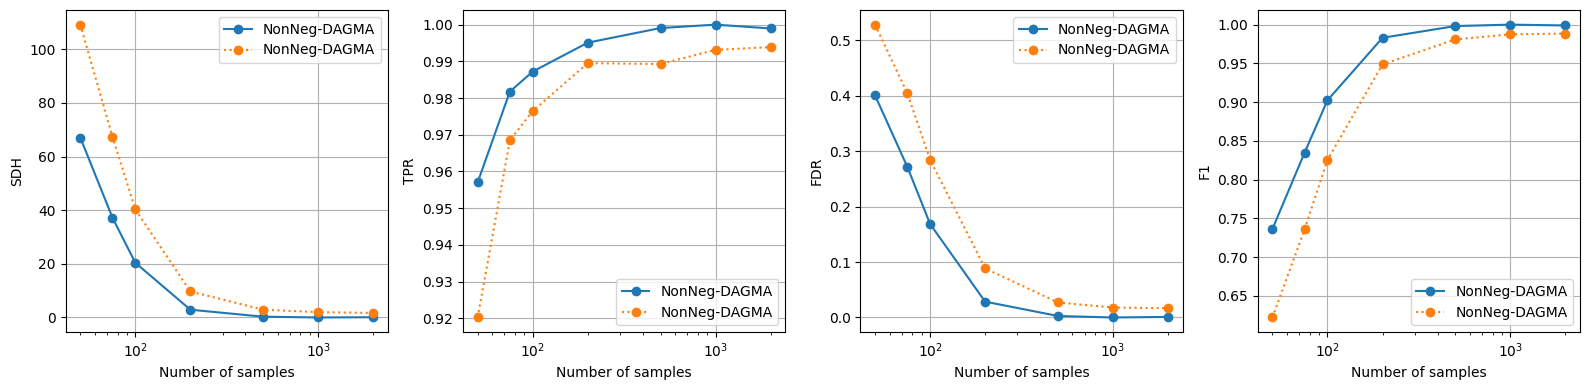

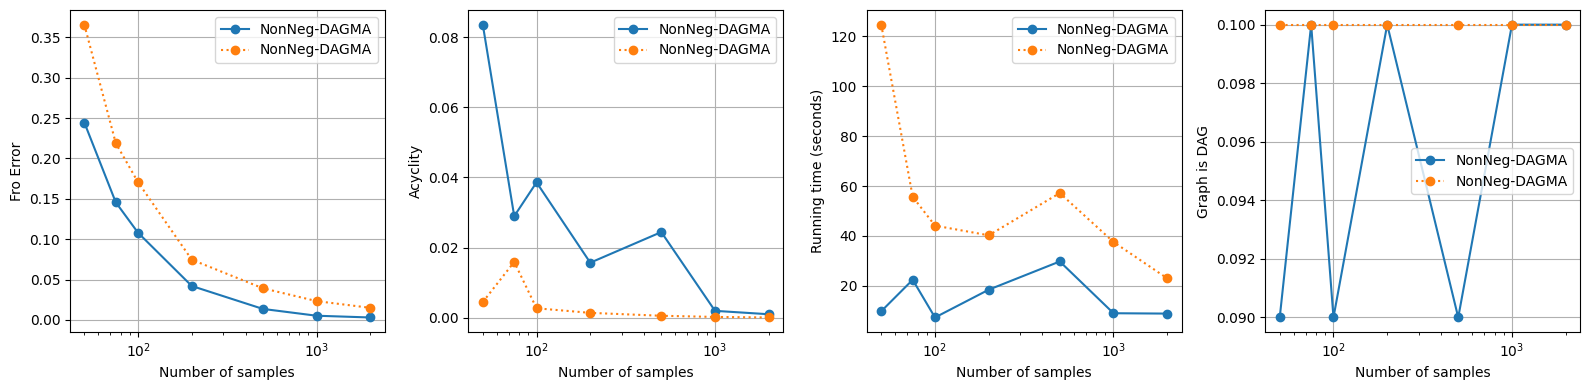

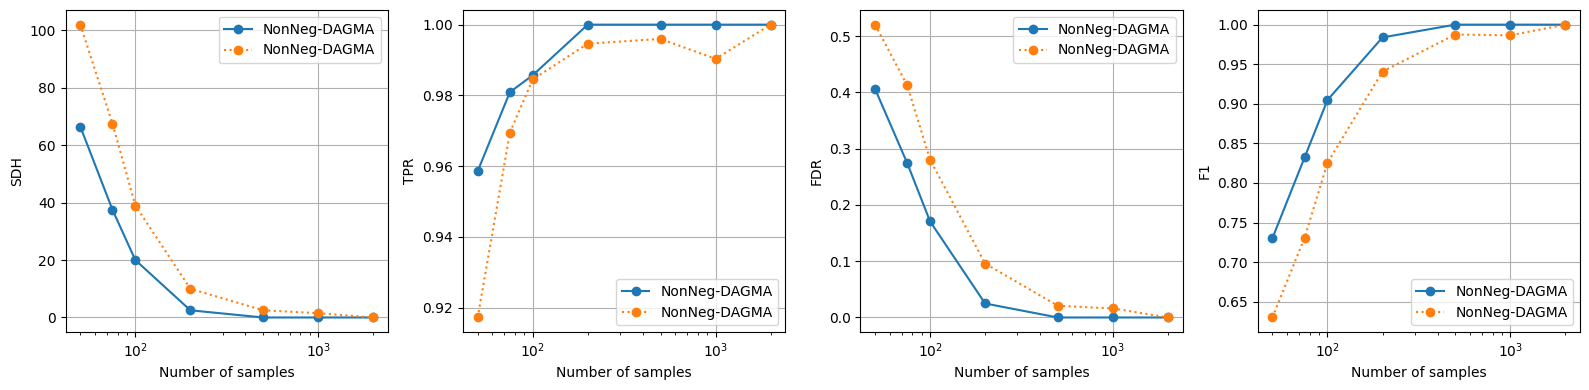

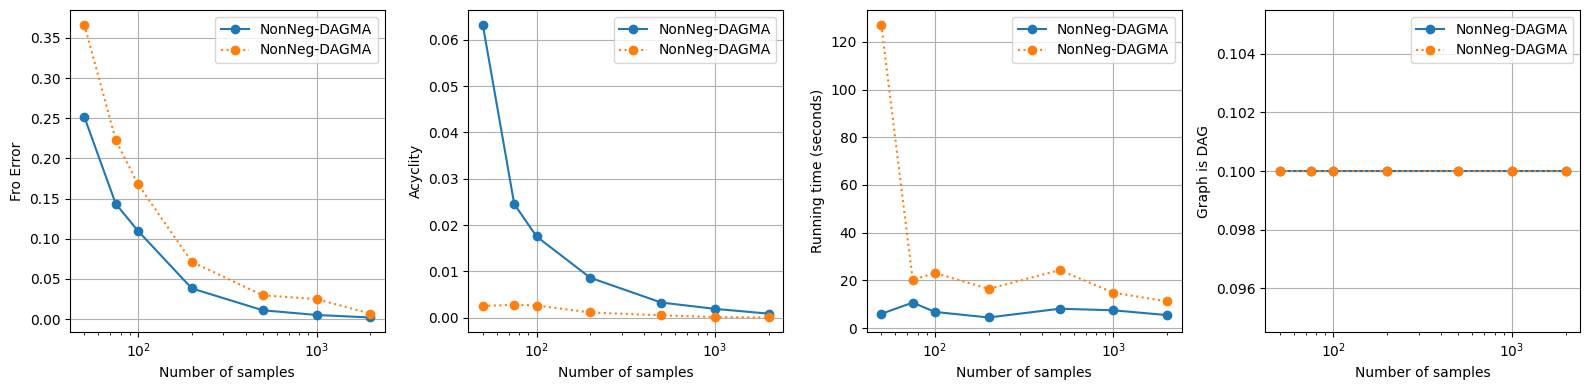

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')
